## Homework 2 - Advanced Business Analytics



In [5]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
from scipy import stats
import scipy.special as sc
from scipy.special import beta

In [6]:
#Bring in data
df = pd.read_excel('C:/Users/User/OneDrive/Desktop/github-repo-folder/adv_bus_analytics/homework_2/hw2_survive_data-2.xlsx')
df.head()

,seq,id,survive
0,1,1999_33,14
1,2,1996_122,19
2,3,1995_43,25+
3,4,1997_78,2
4,5,1997_199,3


### Problem 1

In [7]:
#convert survive column into numeric
# First, clean the survive column by replacing "25+" with "25"
df['survive'] = df['survive'].replace('25+', '25')

# Then convert to numeric
df['survive'] = pd.to_numeric(df['survive'])

#change names of columns
df = df.rename(columns = {
                            'survive': 'week',
                            'id' : 'lost'
                            })

df.head()

,seq,lost,week
0,1,1999_33,14
1,2,1996_122,19
2,3,1995_43,25
3,4,1997_78,2
4,5,1997_199,3


In [8]:
#split data into training and testing dataset

#training set:
train = df[df['seq'] <= 1734]
test = df[df['seq'] > 1734]

print(test)

       seq      lost  week
1734  1735   2002_36    15
1735  1736  1999_227     9
1736  1737   1997_45    25
1737  1738   1995_15     3
1738  1739   1999_17     1
...    ...       ...   ...
2029  2030   1998_51     6
2030  2031  1999_211     1
2031  2032  2001_124    20
2032  2033   1999_23     6
2033  2034  2002_230    25

[300 rows x 3 columns]


In [9]:
#aggregate datasets by column, 'week' values

#testing dataset
train_agg = train.groupby('week').agg({'lost': 'count'})
train_agg = train_agg.reset_index()

# Create new row
new_row = pd.DataFrame({'week': [0], 'lost': [np.nan]})

# Concatenate with existing df, reset the index
train_agg = pd.concat([new_row, train_agg]).reset_index(drop=True)

# Create a new column with remaining records
train_agg['remaining'] = train_agg['lost'].sum() - train_agg['lost'].cumsum()

#add the specific value at begining
#train_agg['lost'][0] = train_agg['lost'].sum()
train_agg.loc[0, "remaining"] = train_agg['lost'].sum()

print(train_agg)

t = train_agg['week']
lost = train_agg['lost']

    week   lost  remaining
0      0    NaN     1734.0
1      1  325.0     1409.0
2      2  177.0     1232.0
3      3  131.0     1101.0
4      4  113.0      988.0
5      5   83.0      905.0
6      6   72.0      833.0
7      7   68.0      765.0
8      8   58.0      707.0
9      9   49.0      658.0
10    10   51.0      607.0
11    11   40.0      567.0
12    12   40.0      527.0
13    13   39.0      488.0
14    14   31.0      457.0
15    15   28.0      429.0
16    16   36.0      393.0
17    17   25.0      368.0
18    18   24.0      344.0
19    19   19.0      325.0
20    20   17.0      308.0
21    21   19.0      289.0
22    22   19.0      270.0
23    23   15.0      255.0
24    24   15.0      240.0
25    25  240.0        0.0


#### Problem 1 - Part a - DELIVERABLE:
The number of albums dropped from top 100 at:

End of Week 1: 325

End of Week 2: 177

End of Week 3: 131

In [71]:
#aggregate datasets by column, 'week' values

#testing dataset
test_agg = test.groupby('week').agg({'lost': 'count'})

test_agg = test_agg.reset_index()

# Create new row
new_row = pd.DataFrame({'week': [0], 'lost': [np.nan]})

# Concatenate with existing df, reset the index
test_agg = pd.concat([new_row, test_agg]).reset_index(drop=True)

# Create a new column with remaining records
test_agg['remaining'] = test_agg['lost'].sum() - test_agg['lost'].cumsum()

#add the specific value at begining
#train_agg['lost'][0] = train_agg['lost'].sum()
test_agg.loc[0, "remaining"] = test_agg['lost'].sum()

print(test_agg)


    week  lost  remaining
0      0   NaN      300.0
1      1  53.0      247.0
2      2  34.0      213.0
3      3  19.0      194.0
4      4  15.0      179.0
5      5  18.0      161.0
6      6  11.0      150.0
7      7  10.0      140.0
8      8   9.0      131.0
9      9  10.0      121.0
10    10   5.0      116.0
11    11  13.0      103.0
12    12   5.0       98.0
13    13   4.0       94.0
14    14   5.0       89.0
15    15   7.0       82.0
16    16   1.0       81.0
17    17   8.0       73.0
18    18   3.0       70.0
19    19   5.0       65.0
20    20   5.0       60.0
21    21   7.0       53.0
22    22   4.0       49.0
23    23   2.0       47.0
24    24   2.0       45.0
25    25  45.0        0.0


In [11]:
#define the function for a geometric distribution with infinite heterogeneity

def mle_geometric_beta(params):
    a = params[0]
    b = params[1]

    #define the BETA FUNCTION
    #define starting lists
    L = [None]*25     #place holder for the log(probabilities)
    Prob = [None]*25
    t = train_agg['week']
    lost = train_agg['lost']

    # Get total initial population (sum of all lost values)
    N0 = lost.sum()

    for i in range(0, 25):
        if i < 24:
            # Calculate the Probability that you churn at t: P(t) using beta function
            Prob[i] = beta(a + 1, b + t[i+1] - 1) / beta(a, b)
            L[i] = np.log(Prob[i])*lost[i+1]
        else:
            Prob_surv = 1 - sum(Prob[0:24])
            L[i] = np.log(Prob_surv)*train_agg['remaining'][i]
    
    LL = -sum(L)
    return LL

In [12]:
#now we need to estimate parameters a and b by minimizing the negative of the summed up log probabilities
starting_values = [1, 1]    #starting values for a and b
bounds = [(0,100), (0,100)]
mle_model = minimize(mle_geometric_beta,
                     x0 = starting_values,
                     method = 'Nelder-mead',
                     options = {'disp': True},
                     bounds = bounds)
mle_model

Optimization terminated successfully.
         Current function value: 4863.519009
         Iterations: 56
         Function evaluations: 107


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4863.519009316078
             x: [ 1.333e+00  7.379e+00]
           nit: 56
          nfev: 107
 final_simplex: (array([[ 1.333e+00,  7.379e+00],
                       [ 1.333e+00,  7.380e+00],
                       [ 1.333e+00,  7.379e+00]]), array([ 4.864e+03,  4.864e+03,  4.864e+03]))

##### Problem 1.2.a - Report the coefficients

alpha = 1.33

beta = 7.38

##### Problem 1.2.b - Testing Set Predicted Remaining vs Actual Remaining

In [13]:
# extracting parameters to make predictions
alpha = mle_model.x[0]
betaa = mle_model.x[1]

Prob1 = [None]*25

for i in range(0, 25):
    if i < 25:
        #calculating the probability of churn at end of time period i, given there would be a churn
        Prob1[i] = beta(alpha + 1, betaa + test_agg['week'][i+1] - 1) / beta(alpha, betaa)
    else:
        #calculate: probablity of churning at time i given that you stayed until time i
        Prob_surv = 1 - sum(Prob1[0:25])
        Prob1[i] = Prob_surv

pred_alive = [None]*25
pred_alive[0] = 300

for i in range(1, 25):
    pred_alive[i] = pred_alive[i-1] - Prob1[i-1]*300

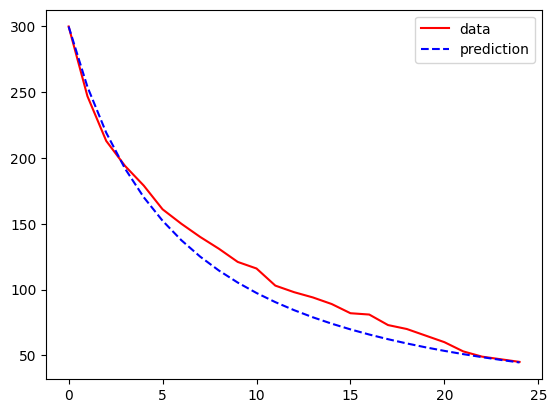

In [14]:
#Actual Dropped Albums
plt.plot(test_agg['week'][0:25], #x-axis
         test_agg['remaining'][0:25], #y-axis
         color='red', 
         label='data')

#Predicted Dropped Albums
plt.plot(test_agg['week'][0:25], #x-axis 
         pred_alive, #y-axis 
         '--',  color='blue', 
         label='prediction')

plt.legend()
plt.show()


#### Problem 1.3 - Exponential Model with 2 Segments on Training Set

In [15]:
print(train_agg)

    week   lost  remaining
0      0    NaN     1734.0
1      1  325.0     1409.0
2      2  177.0     1232.0
3      3  131.0     1101.0
4      4  113.0      988.0
5      5   83.0      905.0
6      6   72.0      833.0
7      7   68.0      765.0
8      8   58.0      707.0
9      9   49.0      658.0
10    10   51.0      607.0
11    11   40.0      567.0
12    12   40.0      527.0
13    13   39.0      488.0
14    14   31.0      457.0
15    15   28.0      429.0
16    16   36.0      393.0
17    17   25.0      368.0
18    18   24.0      344.0
19    19   19.0      325.0
20    20   17.0      308.0
21    21   19.0      289.0
22    22   19.0      270.0
23    23   15.0      255.0
24    24   15.0      240.0
25    25  240.0        0.0


In [ ]:
# we take the first 24 rows
data = train_agg.copy()
data = data[0:24]

def MLE_Exp2Seg(params):
    lamda1 = params[0]
    lamda2 = params[1]
    p = params[2]

    # Find the probability of churning if the customer is from group 1 and if they
    # are from group 2.
    Prob1 = (1 - np.exp(-lamda1 * data.week)) - (1 - np.exp(-lamda1 * (data.week - 1)))
    Prob2 = (1 - np.exp(-lamda2 * data.week)) - (1 - np.exp(-lamda2 * (data.week - 1)))

    # Use the law of total probability.
    Prob = p * Prob1 + (1-p) * Prob2

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning because 1 - F(t) = 1 - cumulative probability of failure before t
    Prob_not_churn_1 = 1 - np.sum(Prob1[1:])
    Prob_not_churn_2 = 1 - np.sum(Prob2[1:])
    
    # Use the law of total probability.
    Prob_not_churn = p * Prob_not_churn_1 + (1-p) * Prob_not_churn_2

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * data.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by week 24.
    LL += np.log(Prob_not_churn) * train_agg.remaining[24]

    return -LL

In [33]:
bounds = [(0, 100), (0, 100), (0.001, 0.99)]
x0 = [0.2, 0.4, 0.5]
mle_model = minimize(MLE_Exp2Seg, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 4758.748600
         Iterations: 95
         Function evaluations: 179


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4758.748599632631
             x: [ 7.376e-02  6.774e-01  7.369e-01]
           nit: 95
          nfev: 179
 final_simplex: (array([[ 7.376e-02,  6.774e-01,  7.369e-01],
                       [ 7.377e-02,  6.775e-01,  7.370e-01],
                       [ 7.377e-02,  6.774e-01,  7.369e-01],
                       [ 7.376e-02,  6.774e-01,  7.370e-01]]), array([ 4.759e+03,  4.759e+03,  4.759e+03,  4.759e+03]))

#### Problem 1.3.a - Report Coefficients

Coefficients:

lamda1 = 0.074

lamda2 = 0.677

p = 0.737


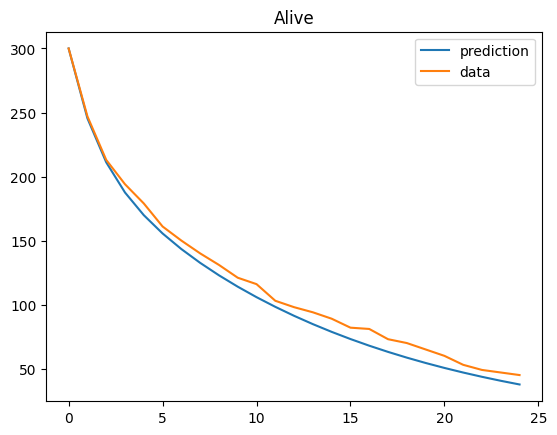

In [72]:
#compare observed hazard with predicted hazard by using estimated parameters with the TESTING dataset

# Note that we use data_in because we want to study all 12 years.

lamda1, lamda2, p = mle_model.x
pop_size = test_agg.remaining[0] # 300 albums was starting population (estimated)

# Estimate how many churns at time t by taking (CDF(t+1) - CDF(t)) * N
Prob1 = (1 - np.exp(-lamda1 * test_agg.week)) - (1 - np.exp(-lamda1 * (test_agg.week - 1)))
Prob2 = (1 - np.exp(-lamda2 * test_agg.week)) - (1 - np.exp(-lamda2 * (test_agg.week - 1)))

# Use the law of total probability.
Prob = p * Prob1 + (1-p) * Prob2

churn = Prob * pop_size
pred_alive = [None] * 25
pred_alive[0] = pop_size

for i in range(1, 25):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(test_agg.remaining[0:25], label='data')
plt.legend()
plt.title('Alive')
plt.show()

#### Problem 1.3.b - DELIVERABLE - Predicted vs Actual Hazard

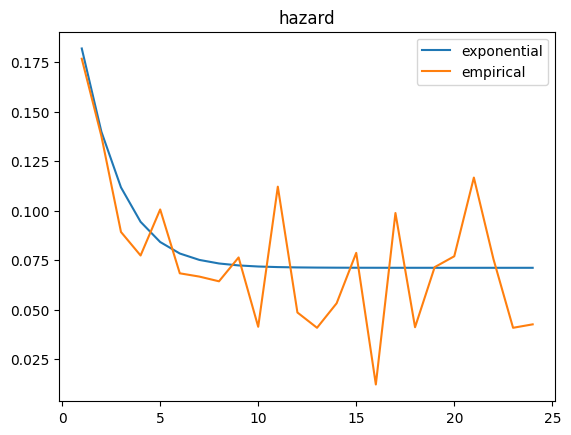

,week,lost,remaining,churn,emp_hazard,pred_hazard
0,0,NaN,300.0,NaN,None,None
1,1,53.0,247.0,54.553635,0.176667,0.181845
2,2,34.0,213.0,34.326906,0.137652,0.139855
3,3,19.0,194.0,23.582671,0.089202,0.111703
4,4,15.0,179.0,17.688300,0.07732,0.094319
5,5,18.0,161.0,14.288379,0.100559,0.084124
6,6,11.0,150.0,12.184324,0.068323,0.078326
7,7,10.0,140.0,10.765291,0.066667,0.075084
8,8,9.0,131.0,9.719108,0.064286,0.073291
9,9,10.0,121.0,8.885445,0.076336,0.072303


In [76]:
# compare actual hazard with predicted hazard using TEST dastaset

pred_haz = [None]*25
for t in range(1, 25):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*25
for t in range(1, 25):
    emp_haz[t] = test_agg.lost[t]/test_agg.remaining[t-1]

plt.plot(pred_haz, label='exponential')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

#add columns for visual check
test_agg.loc[1:25, 'churn'] = churn[1:26]
test_agg.loc[0:24, 'emp_hazard'] = emp_haz
test_agg.loc[0:24, 'pred_hazard'] = pred_haz

test_agg

#### Problem 1.4 - Weibull-Gamma Model

In [78]:
train_agg.head()

,week,lost,remaining
0,0,NaN,1734.0
1,1,325.0,1409.0
2,2,177.0,1232.0
3,3,131.0,1101.0
4,4,113.0,988.0


In [79]:
# we take the first 24 rows
data1 = train_agg.copy()
data1 = data[0:24]

def MLE_Weib_Gamma(params):

    alpha = params[0]
    r = params[1]
    c = params[2]

    # Find the probability of churning.
    F_t = 1 - (alpha/(alpha + data1.week**c))**r
    F_t_minus_1 = 1 - (alpha/(alpha + (data1.week - 1)**c))**r
    Prob = F_t - F_t_minus_1

    # Now find the probability of not churning. It is one minus the sum of all
    # the prior probabilities of churning.
    Prob_not_churn = 1 - np.sum(Prob[1:])

    # Find the sum of log-likelihoods. Be sure to weight by the number of customers
    # churning at each time point. Remember that time t=0 doesn't have a realistic
    # value and should be ignored.
    LL = np.sum(np.log(Prob[1:]) * train_agg.lost[1:])

    # Add in the log-likelihood for the people who hadn't churned by year 7.
    LL += np.log(Prob_not_churn) * train_agg.remaining[24]

    return -LL

In [80]:
bounds = [(0, 100), (0, 100), (0, 100)]
x0 = [1, 1, 1]
mle_model = minimize(MLE_Weib_Gamma, x0 = x0, method='Nelder-mead', bounds=bounds, options={'disp': True})
mle_model

Optimization terminated successfully.
         Current function value: 4756.785749
         Iterations: 250
         Function evaluations: 422


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4756.785748688937
             x: [ 1.000e+02  2.080e+01  7.285e-01]
           nit: 250
          nfev: 422
 final_simplex: (array([[ 1.000e+02,  2.080e+01,  7.285e-01],
                       [ 1.000e+02,  2.080e+01,  7.285e-01],
                       [ 1.000e+02,  2.080e+01,  7.285e-01],
                       [ 1.000e+02,  2.080e+01,  7.285e-01]]), array([ 4.757e+03,  4.757e+03,  4.757e+03,  4.757e+03]))

##### Problem 1.4.a -DELIVERABLE - Report on Coefficients

Coefficients:

alpha = 100

r = 20.8

c = 0.729

#### Problem 1.5.b - DELIVERABLE - Plot Actual Number of Alubums Dropped with Predicted Dropped at End of Each Week

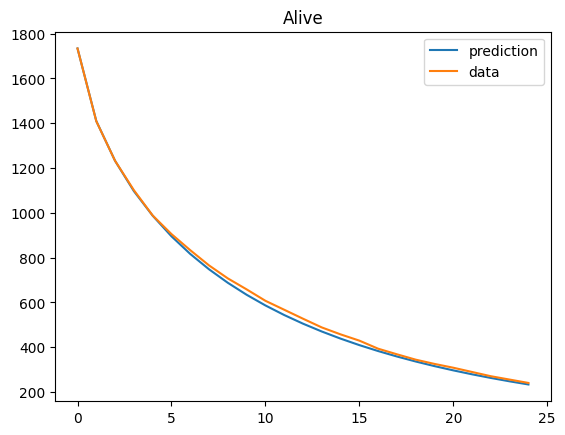

In [82]:
# Note that we use train_agg because we want to study all 25 weeks.
pop_size = train_agg.remaining[0] # 1734 customers

alpha = mle_model.x[0]
r = mle_model.x[1]
c = mle_model.x[2]

# Find the probability of churning.
F_t = 1 - (alpha/(alpha + train_agg.week**c))**r
F_t_minus_1 = 1 - (alpha/(alpha + (train_agg.week - 1)**c))**r
Prob = F_t - F_t_minus_1

churn = Prob * pop_size

pred_alive = [None] * 25
pred_alive[0] = pop_size

for i in range(1, 25):
    pred_alive[i] = pred_alive[i-1] - churn[i]

plt.plot(pred_alive, label='prediction')
plt.plot(train_agg.remaining[0:25], label='data')
plt.legend()
plt.title('Alive')
plt.show()

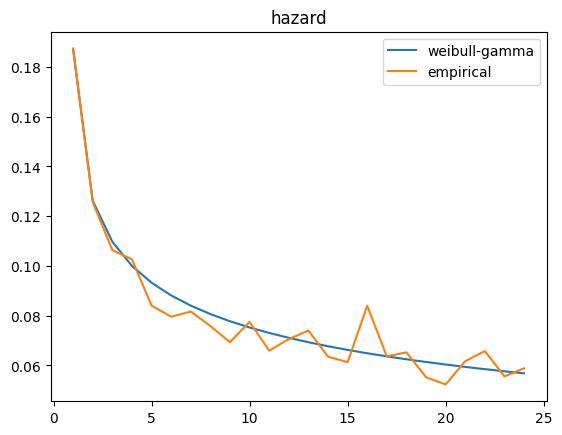

In [84]:
pred_haz = [None]*25
for t in range(1, 25):
    pred_haz[t] = churn[t]/pred_alive[t-1]

emp_haz = [None]*25
for t in range(1, 25):
    emp_haz[t] = train_agg.lost[t]/train_agg.remaining[t-1]

plt.plot(pred_haz, label='weibull-gamma')
plt.plot(emp_haz, label='empirical')
plt.title('hazard')
plt.legend()
plt.show()

## Problem 2 - Survival Momdel - Marriage

In [86]:
#load in the data
df = pd.read_excel('C:/Users/User/OneDrive/Desktop/github-repo-folder/adv_bus_analytics/homework_2/hw2_marriage_data-3.xlsx')
df.head(10)

,id,education,race,years,divorce
0,10016,2,1,1,0
1,33,2,0,1,0
2,141,1,0,1,0
3,310,1,0,1,0
4,537,2,0,1,0
5,551,2,0,1,0
6,566,2,0,1,0
7,786,2,0,1,0
8,798,2,0,1,0
9,856,1,0,1,1


#### Problem 2.1 - weibull with covariates without heterogeneity

In [95]:
#setup dataset
n_user = df.groupby('id')[['education','race','years','divorce']].max()

n_user.head(10)

,education,race,years,divorce
id,,,,
9,2,0,10,0
11,1,0,34,0
13,1,0,2,1
15,1,0,17,1
33,2,0,1,0
36,1,0,48,0
43,3,0,16,0
47,1,0,24,0
50,1,0,24,0


In [97]:
n_user.years.describe()

count    3371.000000
mean       17.937704
std        14.863103
min         1.000000
25%         6.000000
50%        14.000000
75%        26.000000
max        73.000000
Name: years, dtype: float64

In [99]:
n_user.education.describe()

count    3371.000000
mean        1.744883
std         0.666404
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: education, dtype: float64

In [100]:
#define function to maximize

def weibull_exp_cov(param):
    
    lamda=param[0]
    b_educ = param[1]
    b_race = param[2]
    
    #create covariate
    Cov = np.exp(b_educ*n_user.education + b_race*n_user.race)
    new_lambda = Cov * lamda
    Ft = 1-np.exp(-new_lambda*n_user.years)
    Ft1  = 1-np.exp(-new_lambda*(n_user.years-1))

    #For people who adopt we take (Ft-Ft1)
    prob_churn = Ft - Ft1
    L = np.sum(np.log(prob_churn[n_user.divorce==1]))

    #For those who survive we take (1-Ft)
    prob_not_churn = 1 - Ft
    L += np.sum(np.log(prob_not_churn[n_user.divorce==0]))

    return -L

In [102]:
mle_out=minimize(weibull_exp_cov,
                 np.array([0.2,0.2,0.1]), 
                 method='Nelder-mead', 
                 bounds=[{0,10000},{-10000,5},{-10000,5}])

mle_out

c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-package

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5214.623402770199
             x: [ 1.366e-02  1.217e-01  1.359e-01]
           nit: 97
          nfev: 181
 final_simplex: (array([[ 1.366e-02,  1.217e-01,  1.359e-01],
                       [ 1.366e-02,  1.218e-01,  1.359e-01],
                       [ 1.366e-02,  1.218e-01,  1.359e-01],
                       [ 1.366e-02,  1.216e-01,  1.359e-01]]), array([ 5.215e+03,  5.215e+03,  5.215e+03,  5.215e+03]))

#### Problem 2.1.a - DELIVERABLE - Report the coefficients

Coefficients:
1. lambda = 0.0014
2. b_educ = 0.1217
3. b_race = 0.1359

In [126]:
#find probability of divorce for:

#inputs
t = 2
educ = 2
race = 1

#coefficients
lamdba_value = mle_out.x[0]
b_ed_coeff = mle_out.x[1]
b_race_coeff = mle_out.x[2]

#write out the function: F(t) = 1-np.exp(-new_lambda*n_user.years)

cov = np.exp(b_ed_coeff*educ + b_race_coeff*race)
new_lambda = cov * lamdba_value
Ft = 1-np.exp(-new_lambda*t)

print('The probability that a couple in their second year of marriage (t = 2) \nand husband is race = 1, education = 2 is:')
print(round(Ft*100,2), '%')


The probability that a couple in their second year of marriage (t = 2) 
and husband is race = 1, education = 2 is:
3.91 %


#### Problem 2.1.b - DELIVERABLE - probability of divroce for couple
The probability that a couple in their second year of marriage (t = 2) 
and husband is race = 1, education = 2 is:
3.91 %

#### Problem 2.2 - weibull-gamma with covariates

In [112]:
#setup for Weibull-Gamma model with covariates

def weib_cov(param):
    c=param[0]
    lamda=param[1]
    b1_educ = param[2]
    b2_race = param[3]
    #create covariate
    Cov = np.exp(b1_educ*n_user.education + b2_race*n_user.race)
    new_lambda = Cov*lamda
    Ft = 1-np.exp(-new_lambda*(n_user.years)**c)
    Ft1  = 1-np.exp(-new_lambda*(n_user.years-1)**c)

    #For people who adopt we take (Ft-Ft1)
    prob_churn = Ft - Ft1
    L = np.sum(np.log(prob_churn[n_user.divorce==1]))

    #For those who survive we take (1-Ft)
    prob_not_churn = 1 - Ft
    L += np.sum(np.log(prob_not_churn[n_user.divorce==0]))

    return -L

In [ ]:
#do the opimization
mle_out_weibull_gamma_cov=minimize(weib_cov,
                 np.array([0.1, #c > 0
                           0.1, #lambda > 0
                           0.1, #b1_educ -> any number
                           0.1  #b2_race -> any number
                           ]), 
                 method='SLSQP', 
                 bounds=[{0,None},
                         {0,None},
                         {0,100},
                         {0,100}])

mle_out_weibull_gamma_cov

c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\User\OneDrive\Desktop\github-repo-folder\adv_bus_analytics\env_312\Lib\site-package

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5155.789206927841
       x: [ 7.597e-01  2.913e-02  1.041e-01  2.768e-01]
     nit: 21
     jac: [-9.094e-03 -3.607e-02 -4.456e-03  5.493e-04]
    nfev: 123
    njev: 21

#### Problem 2.1.a - Report on coefficients

Coefficients:
1. lambda = 0.760
2. c = 0.029, 
3. b1_education = 0.104
4. b2_race = 0.277

In [125]:
#find probability of divorce for:

#inputs
t = 2
educ = 2
race = 1

#coefficients
c_value = mle_out_weibull_gamma_cov.x[0]
lamdba2_value = mle_out_weibull_gamma_cov.x[1]
b_ed_coeff2 = mle_out_weibull_gamma_cov.x[2]
b_race_coeff2 = mle_out_weibull_gamma_cov.x[3]

#write out the function: F(t) = 1-np.exp(-new_lambda*n_user.years)

cov2 = np.exp(b_ed_coeff2*educ + b_race_coeff2*race)
new_lambda2 = cov2 * lamdba2_value
Ft2 = 1-np.exp(-new_lambda2*t)

print('Using Weibull-Gamma with Covariates Modelling: \nThe probability that a couple in their second year of marriage (t = 2) \nand husband is race = 1, education = 2 is:')
print(round(Ft2*100,2), '%')

Using Weibull-Gamma with Covariates Modelling: 
The probability that a couple in their second year of marriage (t = 2) 
and husband is race = 1, education = 2 is:
9.03 %


#### Problem 2.2.b - Probability of Divorce with Weibull-Gamma with Covariates Model

Using Weibull-Gamma with Covariates Modelling: 
The probability that a couple in their second year of marriage (t = 2) 
and husband is race = 1, education = 2 is:
9.03 %

In [ ]:
#Calculate BIC for both models
pop_size = n_user.shape[0]
print('population size is:', pop_size)

#weibull exponential with covariates
num_params = 3
BIC_weibull_exp_cov = num_params * np.log(pop_size) - 2 * (-mle_out.fun)
print('BIC for Weibull Exponential with Covariates Model:', BIC_weibull_exp_cov)

#weibull gamma with covariates:
num_params = 4
BIC_weibull_gamma_cov = num_params * np.log(pop_size) - 2 * (-mle_out_weibull_gamma_cov.fun)
print('BIC for Weibull Gamma with Covariates Model:', BIC_weibull_gamma_cov)

print('\n')
print('The better model is the Weibull-Gamma Model with Covariates.  It has a smaller BIC.')

population size is: 3371
BIC for Weibull Exponential with Covariates Model: 10453.615699686101
BIC for Weibull Gamma with Covariates Model: 10344.070272716619
